In [1]:
!nvidia-smi

Mon Jun  9 05:43:57 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Same as UNet

In [4]:
import opendatasets as od

dataset_url = "https://www.kaggle.com/datasets/carlolepelaars/camvid"
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: yuvrajbalagoni
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/carlolepelaars/camvid


100%|██████████| 575M/575M [00:06<00:00, 93.8MB/s]

In [5]:
import os
from pathlib import Path
from PIL import Image

data_path = "camvid/CamVid"
data_dir = Path(data_path)

train_img_dir = Path(os.path.join(data_dir, "train"))
train_mask_dir = Path(os.path.join(data_dir, "train_labels"))
test_img_dir = Path(os.path.join(data_dir, "test"))
test_mask_dir = Path(os.path.join(data_dir, "test_labels"))
val_img_dir = Path(os.path.join(data_dir, "val"))
val_mask_dir = Path(os.path.join(data_dir, "val_labels"))

test_img_list = list(test_img_dir.glob("*.png"))
test_mask_list = list(test_mask_dir.glob("*.png"))
test_img_list.sort()
test_mask_list.sort()

for i in range(len(test_img_list) - 100):
  os.rename(test_img_list[i], os.path.join(train_img_dir, test_img_list[i].name))
  os.rename(test_mask_list[i], os.path.join(train_mask_dir, test_mask_list[i].name))

print(len(os.listdir(train_img_dir)), len(os.listdir(train_mask_dir)))
print(len(os.listdir(test_img_dir)), len(os.listdir(test_mask_dir)))
print(len(os.listdir(val_img_dir)), len(os.listdir(val_mask_dir)))

501 501
100 100
100 100


In [6]:
import pandas as pd
class_dict = pd.read_csv("camvid/CamVid/class_dict.csv")
class_dict

,name,r,g,b
0,Animal,64,128,64
1,Archway,192,0,128
2,Bicyclist,0,128,192
3,Bridge,0,128,64
4,Building,128,0,0
5,Car,64,0,128
6,CartLuggagePram,64,0,192
7,Child,192,128,64
8,Column_Pole,192,192,128
9,Fence,64,64,128


In [7]:
import os
from PIL import Image
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import numpy as np

class CamVidDataset(Dataset):
  def __init__(self, image_dir, mask_dir, transform=None):
    self.image_dir = image_dir
    self.mask_dir = mask_dir
    self.transform = transform
    self.images = os.listdir(image_dir)
    self.masks = os.listdir(mask_dir)

  def __len__(self):
    return len(self.images)

  def __getitem__(self, index):
    img_path = os.path.join(self.image_dir, self.images[index])
    basename, extension = os.path.splitext(self.images[index])
    maskname = basename + "_L" + extension
    mask_path = os.path.join(self.mask_dir, maskname)
    image = np.array(Image.open(img_path).convert("RGB"))
    mask = np.array(Image.open(mask_path).convert("RGB"))
    mask[mask == 255.0] = 1.0

    if self.transform is not None:
      augmentations = self.transform(image=image, mask=mask)
      image = augmentations["image"]
      mask = augmentations["mask"]

    return image, mask

In [8]:
from torch.utils.data import DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

train_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.HorizontalFlip(p=0.5),
        A.Normalize(
            mean = [0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        A.ToTensorV2(),
    ],
)
val_transform = A.Compose(
    [
        A.Resize(height=512, width=512),
        A.Normalize(
            mean = [0.0, 0.0, 0.0],
            std = [1.0, 1.0, 1.0],
            max_pixel_value = 255.0
        ),
        A.ToTensorV2(),
    ],
)

In [9]:
import torch.nn as nn

class CombineLoss(nn.Module):
  """
  Args:
      class_rgb (torch.Tensor): RGB values per class. Shape [num_classes, 3]
      alpha (float): Weight for CrossEntropy (0.5 by default)
      smooth (float): Smoothing factor for Dice (1e-6 by default)
  """
  def __init__(self, class_rgb, alpha=0.5, smooth=1e-6):
    super(CombineLoss, self).__init__()
    self.class_rgb = class_rgb.view(32,1,1,3)
    self.smooth = smooth
    self.alpha = alpha
    self.ce_loss = nn.CrossEntropyLoss()

  def _rgb_to_indices(self, target):
    matches = (target.unsqueeze(1) == self.class_rgb).all(dim=-1)
    return matches.float().argmax(dim=1)

  def _dice_loss(self, pred, target_indices):
    num_classes = pred.shape[1]
    targets_onehot = torch.eye(num_classes, device=pred.device)[target_indices]
    targets_onehot = targets_onehot.permute(0, 3, 1, 2)

    pred_probs = torch.softmax(pred, dim=1)
    intersection = torch.sum(pred_probs * targets_onehot, dim=(2, 3))
    union = torch.sum(pred_probs + targets_onehot, dim=(2, 3))

    dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
    return 1 - dice.mean()

  def forward(self, pred, target):
    """
    Args:
        pred (torch.Tensor): Model logits (unactivated). Shape [B, Num_Classes, H, W]
        target (torch.Tensor): Ground truth RGB. Shape [B, H, W, 3]
    """
    target_indices = self._rgb_to_indices(target)
    ce = self.ce_loss(pred, target_indices)
    dice = self._dice_loss(pred, target_indices)
    return self.alpha * ce + (1 - self.alpha) * dice

In [10]:
import torch
# Dice Coefficient & IoU.
def rgb_to_indices(target, class_rgb):
  class_rgb = class_rgb.view(32,1,1,3)
  matches = (target.unsqueeze(1) == class_rgb).all(dim=-1)
  return matches.float().argmax(dim=1)

def Compute_IOU(pred, target, num_classes=32, smooth=1e-6):
  """
  Args:
      preds: [B, Num_Classes, H, W] (logits)
      targets: [B, H, W] (class indices)
      class_rgb: [Num_Classes, 3]
      num_classes: int
      smooth: smoothing factor
  Returns:
      iou_per_class: [Num_Classes]
      mean_iou: scalar
  """
  preds = torch.argmax(pred, dim=1)
  identity_tensor = torch.eye(num_classes).to(pred.device)
  pred_onehot = identity_tensor[preds].permute(0,3,1,2).to(pred.device)
  target_onehot = identity_tensor[target].permute(0,3,1,2).to(pred.device)

  intersection = (pred_onehot.bool() & target_onehot.bool()).float().sum(dim=(0, 2, 3))
  union = (pred_onehot.bool() | target_onehot.bool()).float().sum(dim=(0, 2, 3))

  iou_per_class = (intersection + smooth) / (union + smooth)
  mean_iou = iou_per_class[~torch.isnan(iou_per_class)].mean()

  return iou_per_class, mean_iou

def Compute_Dice(pred, target, num_classes=32, smooth=1e-6):
  """
  Args:
      preds: [B, Num_classes, H, W] (logits)
      targets: [B, H, W] (class indices)
      num_classes: int
      smooth: smoothing factor
  Returns:
      dice_per_class: [C]
      mean_dice: scalar
  """
  preds = torch.argmax(pred, dim=1)
  identity_tensor = torch.eye(num_classes).to(pred.device)
  preds_onehot = identity_tensor[preds].permute(0, 3, 1, 2).to(preds.device)
  targets_onehot = identity_tensor[target].permute(0, 3, 1, 2).to(preds.device)

  intersection = (preds_onehot * targets_onehot).float().sum(dim=(0, 2, 3))
  preds_sum = preds_onehot.float().sum(dim=(0, 2, 3))
  targets_sum = targets_onehot.float().sum(dim=(0, 2, 3))

  dice_per_class = (2.0 * intersection + smooth) / (preds_sum + targets_sum + smooth)
  mean_dice = dice_per_class[~torch.isnan(dice_per_class)].mean()

  return dice_per_class, mean_dice

# AttentionUNet Model

In [11]:
torch.manual_seed(1)
x = torch.randn(1,3,572,572)
x.shape

torch.Size([1, 3, 572, 572])

In [29]:
import torch.nn.functional as F

class DoubleConv(nn.Module):
  def __init__(self, in_channels, out_channels):
    super(DoubleConv, self).__init__()
    self.conv = nn.Sequential(
        nn.Conv2d(in_channels = in_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
        nn.Conv2d(in_channels = out_channels,
                  out_channels = out_channels,
                  kernel_size = 3,
                  stride = 1,
                  padding = 1,
                  bias=False),
        nn.BatchNorm2d(out_channels),
        nn.ReLU(inplace=True),
    )

  def forward(self, x):
    return self.conv(x)

class AttentionGates(nn.Module):
  def __init__(self, in_channels_x, in_channels_g, inter_channels):
    super(AttentionGates, self).__init__()
    self.W_g = nn.Conv2d(in_channels = in_channels_g,
                         out_channels = inter_channels,
                         kernel_size=1,
                         stride=1,
                         bias=False)
    self.W_x = nn.Conv2d(in_channels = in_channels_x,
                         out_channels = inter_channels,
                         kernel_size=1,
                         stride=1,
                         bias=False)
    self.sigma_1 = nn.ReLU(inplace=True)
    self.phi = nn.Conv2d(in_channels = inter_channels,
                         out_channels = 1,
                         kernel_size=1,
                         stride=1,
                         bias=False)
    self.sigma_2 = nn.Sigmoid()

  def forward(self, x, g):
    g = F.interpolate(g, scale_factor=2, mode='bilinear', antialias=False)
    summation = self.W_g(g) + self.W_x(x)
    q_att = self.phi(self.sigma_1(summation))
    attentions_coeff = self.sigma_2(q_att)
    return (x * attentions_coeff)

class AttentionUNet(nn.Module):
  def __init__(self, in_channels = 3, out_channels = 32):
    super(AttentionUNet, self).__init__()
    self.in_channels = in_channels
    self.out_channels = out_channels
    self.shapes = [64, 128, 256]
    self.maxpool = nn.MaxPool2d(kernel_size = 2,
                                stride = 2)

    self.down = nn.ModuleList()
    self.up = nn.ModuleList()
    self.upconv = nn.ModuleList()
    self.AGs = nn.ModuleList()

    for shape in self.shapes:
      self.down.append(DoubleConv(self.in_channels, shape))
      self.in_channels = shape

    self.bottleneck = DoubleConv(self.shapes[-1], self.shapes[-1]*2)

    self.up = nn.ModuleList([
          nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2),
          nn.ConvTranspose2d(128, 128, kernel_size=2, stride=2),
          nn.ConvTranspose2d(64, 64, kernel_size=2, stride=2),
    ])

    self.upconv = nn.ModuleList([
            DoubleConv(256, 128),
            DoubleConv(128, 64),
    ])

    self.AGs = nn.ModuleList([
            AttentionGates(256, 512, 128),
            AttentionGates(128, 128, 64),
            AttentionGates(64, 64, 32),
    ])

    self.final_conv = nn.Conv2d(self.shapes[0], self.out_channels, kernel_size=1)

  def forward(self, x):
    skip_connections = []

    for down in self.down:
      x = down(x)
      skip_connections.append(x)
      x = self.maxpool(x)

    x = self.bottleneck(x)

    skip_connections = skip_connections[::-1]

    for i in range(len(self.shapes)):
      AG_output = self.AGs[i](skip_connections[i], x)
      x = self.up[i](x)
      concat_skip = torch.concat((AG_output, x), dim=1)
      if i < len(self.shapes) - 1:
        x = self.upconv[i](x)

    x = self.final_conv(x)
    return x

In [30]:
from torchinfo import summary
model = AttentionUNet(3, 32)
summary(
    model=model,
    input_size=(1, 3, 512, 512),
    col_names=["input_size", "output_size", "num_params", "trainable"]
)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Trainable
AttentionUNet                            [1, 3, 512, 512]          [1, 32, 512, 512]         --                        True
├─ModuleList: 1-5                        --                        --                        (recursive)               True
│    └─DoubleConv: 2-1                   [1, 3, 512, 512]          [1, 64, 512, 512]         --                        True
│    │    └─Sequential: 3-1              [1, 3, 512, 512]          [1, 64, 512, 512]         38,848                    True
├─MaxPool2d: 1-2                         [1, 64, 512, 512]         [1, 64, 256, 256]         --                        --
├─ModuleList: 1-5                        --                        --                        (recursive)               True
│    └─DoubleConv: 2-2                   [1, 64, 256, 256]         [1, 128, 256, 256]        --                        True
│    

In [31]:
from tqdm.auto import tqdm
import onnx
from torch.amp import autocast, GradScaler
import wandb

device = "cuda" if torch.cuda.is_available() else "cpu"

config = {
    "Architecture": "Attention-UNet",
    "LR": 0.001,
    "Epochs": 10,
    "Batch_Size": 2,
    "loss_alpha": 0.5,
}

run = wandb.init(project="Image_Segmentation", config=config)

config = run.config

train_data = CamVidDataset(
    image_dir=train_img_dir,
    mask_dir=train_mask_dir,
    transform= train_transform
)
val_data = CamVidDataset(
    image_dir=val_img_dir,
    mask_dir=val_mask_dir,
    transform= val_transform
)

train_dataloader = DataLoader(train_data,
                              batch_size=config.Batch_Size,
                              shuffle=True)
val_dataloader = DataLoader(val_data,
                            batch_size=config.Batch_Size,
                            shuffle=False)

# os.environ['PYTORCH_CUDA_ALLOC_CONF'] = 'expandable_segments:True,max_split_size_mb:512'
UNet_Model = AttentionUNet(in_channels=3, out_channels=32).to(device)

result = {
    "train loss": [],
    "train miou": [],
    "train dice": [],
    "val loss": [],
    "val miou": [],
    "val dice": []
}

class_rgb = torch.tensor(class_dict.iloc[:, 1:].values, dtype=torch.float64).to(device)

loss_fn = CombineLoss(class_rgb = class_rgb, alpha = config.loss_alpha)
optimizer = torch.optim.Adam(UNet_Model.parameters(),
                             lr = config.LR)

for epoch in tqdm(range(config.Epochs)):
  UNet_Model.train()
  train_loss, train_miou, train_dice = 0, 0, 0

  scaler = GradScaler('cuda')
  for batch_idx, (x,y) in enumerate(train_dataloader):
    x,y = x.to(device), y.to(device)
    with autocast('cuda'):
      y_pred = UNet_Model(x).to(device)
      loss = loss_fn(y_pred, y)
    train_loss += loss.item()

    optimizer.zero_grad()
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()

    y = rgb_to_indices(y, class_rgb)

    _, mean_iou = Compute_IOU(y_pred, y)
    _, mean_dice = Compute_Dice(y_pred, y)

    train_miou += mean_iou
    train_dice += mean_dice

  train_loss /= len(train_dataloader)
  train_miou /= len(train_dataloader)
  train_dice /= len(train_dataloader)

  UNet_Model.eval()
  val_loss, val_miou, val_dice = 0, 0, 0

  with torch.inference_mode():
    for batch_idx, (x,y) in enumerate(val_dataloader):
      x,y = x.to(device), y.to(device)

      with autocast('cuda'):
        y_pred = UNet_Model(x).to(device)
        loss = loss_fn(y_pred, y)
      val_loss += loss.item()

      y = rgb_to_indices(y, class_rgb)

      _, mean_iou = Compute_IOU(y_pred, y)
      _, mean_dice = Compute_Dice(y_pred, y)

      val_miou += mean_iou
      val_dice += mean_dice

    val_loss /= len(val_dataloader)
    val_miou /= len(val_dataloader)
    val_dice /= len(val_dataloader)

  result["train loss"].append(train_loss.item() if isinstance(train_loss, torch.Tensor) else train_loss)
  result["train miou"].append(train_miou.item() if isinstance(train_miou, torch.Tensor) else train_miou)
  result["train dice"].append(train_dice.item() if isinstance(train_dice, torch.Tensor) else train_dice)
  result["val loss"].append(val_loss.item() if isinstance(val_loss, torch.Tensor) else val_loss)
  result["val miou"].append(val_miou.item() if isinstance(val_miou, torch.Tensor) else val_miou)
  result["val dice"].append(val_dice.item() if isinstance(val_dice, torch.Tensor) else val_dice)

  run.log(
      {
          "epoch": epoch + 1,
          "train loss": train_loss,
          "train miou": train_miou,
          "train dice": train_dice,
          "val loss": val_loss,
          "val miou": val_miou,
          "val dice": val_dice
      }
  )

  print(f"Epoch {epoch + 1}/{config.Epochs}: train loss: {train_loss:.4f} | train miou: {train_miou:.4f} | train dice: {train_dice:.4f} | val loss: {val_loss:.4f} | val miou: {val_miou:.4f} | val dice: {val_dice:.4f}")

  model_path = Path("Models/")
  if model_path.is_dir() == False:
    model_path.mkdir()

torch.onnx.export(
    UNet_Model,
    torch.randn(1,3,512,512, device=device),
    "Models/unet_model.onnx",
    input_names=["input"],
    output_names=["output"],
)

run.log_artifact("Models/unet_model.onnx", type = "Model")
print("Model training Completed")
run.finish()

  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/10: train loss: 1.2330 | train miou: 0.4301 | train dice: 0.4439 | val loss: 1.2048 | val miou: 0.4292 | val dice: 0.4442
Epoch 2/10: train loss: 1.0841 | train miou: 0.4561 | train dice: 0.4742 | val loss: 1.0536 | val miou: 0.4417 | val dice: 0.4601
Epoch 3/10: train loss: 1.0307 | train miou: 0.4665 | train dice: 0.4860 | val loss: 0.9832 | val miou: 0.4560 | val dice: 0.4768
Epoch 4/10: train loss: 1.0014 | train miou: 0.4700 | train dice: 0.4908 | val loss: 1.0790 | val miou: 0.4524 | val dice: 0.4731
Epoch 5/10: train loss: 0.9664 | train miou: 0.4763 | train dice: 0.4984 | val loss: 0.9302 | val miou: 0.4725 | val dice: 0.4962
Epoch 6/10: train loss: 0.9233 | train miou: 0.4788 | train dice: 0.5025 | val loss: 0.9202 | val miou: 0.4637 | val dice: 0.4873
Epoch 7/10: train loss: 0.8885 | train miou: 0.4832 | train dice: 0.5090 | val loss: 0.8837 | val miou: 0.4763 | val dice: 0.5009
Epoch 8/10: train loss: 0.8545 | train miou: 0.4907 | train dice: 0.5193 | val loss: 0.831

epoch,▁▂▃▃▄▅▆▆▇█
train dice,▁▃▄▅▅▅▆▇▇█
train loss,█▆▅▄▄▃▂▂▁▁
train miou,▁▃▄▅▅▆▆▇▇█
val dice,▁▂▄▃▅▄▆▆▇█
val loss,█▅▄▆▃▃▃▂▁▁
val miou,▁▂▄▃▅▅▆▆▇█
epoch,10
train dice,0.53697
train loss,0.80625
train miou,0.50331


In [32]:
test_dataset = CamVidDataset(
    image_dir = test_img_dir,
    mask_dir = test_mask_dir,
    transform = val_transform
)

x = test_dataset[26][0].unsqueeze(dim=0)
y = test_dataset[26][1]

UNet_Model.eval()
with torch.inference_mode():
  x,y = x.to(device), y.to(device)
  y_pred = UNet_Model(x).to(device)

softmax = torch.nn.Softmax(dim=1)
y_pred_prob = softmax(y_pred)
y_pred_labels = torch.argmax(y_pred_prob, dim=1)

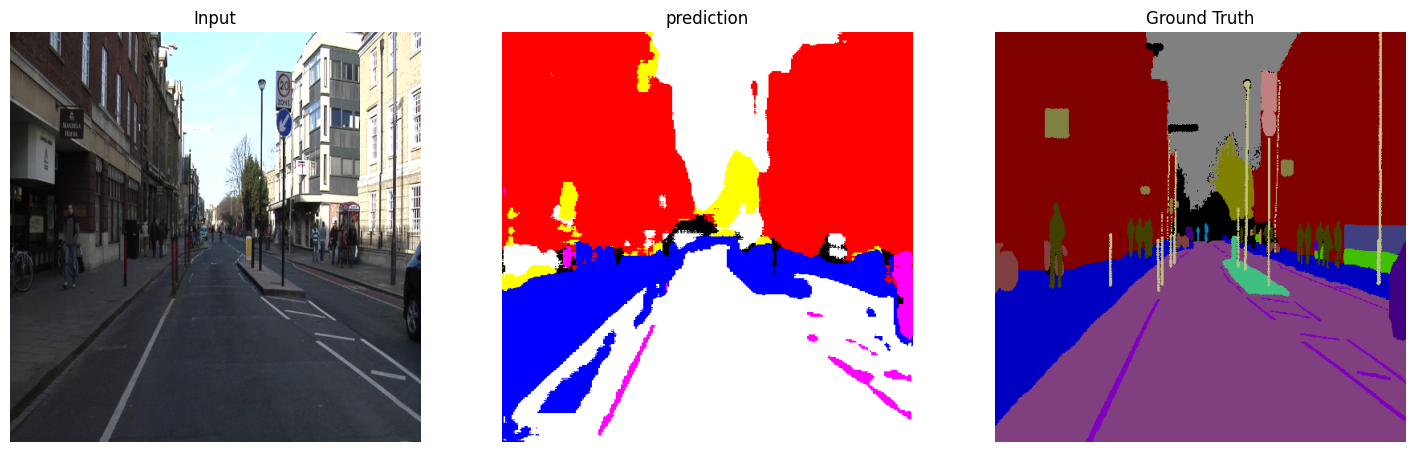

In [33]:
predicted_mask = class_rgb[y_pred_labels].squeeze(dim=0)
true_mask = y
x = x.squeeze(dim=0).permute(1,2,0)

plt.figure(figsize=(18,6))

plt.subplot(1,3,1)
plt.imshow(x.cpu())
plt.title("Input", fontsize=12)
plt.axis(False);

plt.subplot(1,3,2)
plt.imshow(predicted_mask.cpu())
plt.title("prediction", fontsize=12)
plt.axis(False);

plt.subplot(1,3,3)
plt.imshow(true_mask.cpu())
plt.title("Ground Truth", fontsize=12)
plt.axis(False);

plt.show()